In [1]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric
!pip install -q ogb>=1.3.0

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from time import time

from google.colab import widgets
from ipywidgets import interact, interact_manual, FloatSlider
import pandas as pd
import torch

# # Periodic table thanks to Chris Andrejewski <christopher.andrejewski@gmail.com>
# link = "https://raw.githubusercontent.com/andrejewski/periodic-table/master/data.csv"
# elements = pd.read_csv(
#     link, index_col=0, sep=", ", engine="python",
#      converters = dict(symbol= lambda text: text.strip())
# )

     |████████████████████████████████| 2.6MB 2.0MB/s 
     |████████████████████████████████| 1.5MB 2.0MB/s 
     |████████████████████████████████| 194kB 5.8MB/s 
     |████████████████████████████████| 235kB 7.8MB/s 
     |████████████████████████████████| 2.2MB 8.1MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 


# Molecules classification

## The dataset

We study the [`ogbg-molhiv` dataset][1].
Each graph represents a molecule, where nodes are atoms, and edges are chemical bonds. Input node features are 9-dimensional, containing atomic number and chirality, as well as other additional atom features such as formal charge and whether the atom is in the ring or not.

## The task

We want to predict whether a molecule inhibits HIV virus replication or not, as accurately as possible,

[1]: https://ogb.stanford.edu/docs/graphprop/

## Data Loading

In [2]:
AIDS_LABEL_ENC = pd.Series(data = [
    "C", "O", "N", "Cl", "F", "S",
    "Se", "P", "Na", "I", "Co", "Br",
    "Li", "Si", "Mg", "Cu", "As", "B",
    "Pt", "Ru", "K", "Pd", "Au", "Te",
    "W", "Rh", "Zn", "Bi", "Pb", "Ge",
    "Sb", "Sn", "Ga", "Hg", "Ho", "Tl",
    "Ni", "Tb"
])

print(len(AIDS_LABEL_ENC))

38


In [3]:
MUT_LABEL_ENC = pd.Series(data = ["C","O", "Cl","H","N","F","Br","S","P","I","Na","K","Li","Ca"])
print(len(MUT_LABEL_ENC))

14


In [4]:
# IMPORTS
#from ogb.graphproppred import PygGraphPropPredDataset # Dataset package

from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader # Utility to load data
from torch_geometric.transforms import Compose

#### Transforms

To properly analyze the dataset, we need to define a few **transforms**.

In [5]:
class AddSymbols(object):
    """
    Add the symbol of the elements, from the atomic number, as a key of the graph
    """
    def __call__(self, graph):
        #graph.symbols = elements.loc[graph.x[:,0] + 1, "symbol"].values
        graph.symbols = MUT_LABEL_ENC.loc[graph.x.argmax(dim=-1)].values
       
        return graph


In [6]:
dataset = TUDataset(
    root=".", name="Mutagenicity",
    transform=AddSymbols(),
).shuffle()

Extracting ./Mutagenicity/Mutagenicity.zip
Processing...
Done!


### Features

From the [doc](https://github.com/snap-stanford/ogb/blob/master/ogb/utils/features.py).

---

**Atom** (node) features:

Atom type one-hot encoded.

**Bond** (edge) features:

Bond type one-hot encoded.

In [7]:
import numpy as np

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Samples per class: {[ np.sum([1 for graph in dataset if graph.y == i ]) for i in range(dataset.num_classes) ]}')

all_atoms = np.concatenate(
    [graph.symbols for graph in dataset]
)

print()
print(f"{len(np.unique(all_atoms))} unique atoms: {np.unique(all_atoms)}")

_el0 = dataset[0]  # Get the first graph object.

print()
print(_el0)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {_el0.num_nodes}')
print(f'Number of edges: {_el0.num_edges}')
print(f'Average node degree: {_el0.num_edges / _el0.num_nodes:.2f}')
print(f'Contains isolated nodes: {_el0.contains_isolated_nodes()}')
print(f'Contains self-loops: {_el0.contains_self_loops()}')
print(f'Is undirected: {_el0.is_undirected()}')


Dataset: Mutagenicity(4337):
Number of graphs: 4337
Number of features: 14
Number of classes: 2
Samples per class: [2401, 1936]

14 unique atoms: ['Br' 'C' 'Ca' 'Cl' 'F' 'H' 'I' 'K' 'Li' 'N' 'Na' 'O' 'P' 'S']

Data(edge_attr=[80, 3], edge_index=[2, 80], symbols=['C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'N' 'C'
 'N' 'C' 'C' 'O' 'O' 'O' 'O' 'C' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H'], x=[36, 14], y=[1])
Number of nodes: 36
Number of edges: 80
Average node degree: 2.22
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


## Visualization

We will use a graph visualization library to represent the molecules.

_NOTE: consider writing interactively the basic plot function:_
```
    torch_graph -> networkx.Graph
    networkx.draw(networkx.Graph)
```

In [288]:
# DEFINE VISUALIZATION FUNCTIONS
import networkx as nx  # Graph manipulation library
from torch_geometric.utils import to_networkx  # Conversion function

def to_molecule(torch_graph, remove_isolated=True):
    G = to_networkx(
        torch_graph,
        to_undirected=True,
        node_attrs=["symbols"]
    )
    return G


def plot_mol(
    G: nx.Graph,
    edge_mask=None,
    edge_type=None,
    threshold=None,
    drop_isolates=None,
    ax=None
):
    if drop_isolates is None:
        drop_isolates = True if threshold else False
    if ax is None:
        fig, ax = plt.subplots(dpi=120)

    pos = nx.planar_layout(G)
    pos = nx.kamada_kawai_layout(G, pos=pos)

    if edge_type is None:
        widths = None
    else:
        widths = edge_type + 1

    edgelist = G.edges()

    if edge_mask is None:
        edge_color = 'black'
    else:
        if threshold is not None:
            edgelist = []
            new_widths = []
            for i, (u, v) in enumerate(G.edges()):
                if edge_mask[(u,v)] > threshold:
                    edgelist.append((u,v))
                    if widths is not None:
                        new_widths.append(widths[i])
            if widths is not None:
                widths = new_widths
        edge_color = [edge_mask[(u, v)] for u, v in edgelist]
    
    nodelist = G.nodes()
    if drop_isolates:
        if not edgelist:  # Prevent errors
            ax.text(0, 0, "No nodes left to show !", ha="center")
            return

        nodelist = list(set.union(*map(set,edgelist)))

    node_labels = {
        node: data["symbols"] for node, data in G.nodes(data=True)
        if node in nodelist
    }

    nx.draw_networkx(
        G, pos=pos,
        nodelist=nodelist,
        node_size=200,
        labels=node_labels,
        width=widths,
        edgelist=edgelist,
        edge_color=edge_color, edge_cmap=plt.cm.Blues,
        edge_vmin=0., edge_vmax=1.,
        node_color='azure',
        ax=ax
    )

    if ax is None:
        fig.tight_layout()
        plt.show()


In [268]:
interact(
    lambda graph: plot_mol(
        to_molecule(dataset[graph]),
        edge_type=dataset[graph].edge_attr[:,0].numpy(),
    ),
    graph=range(len(dataset))
)

interactive(children=(Dropdown(description='graph', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

<function __main__.<lambda>>

## Graph neural networks

We will use the [**Pytorch Geometric**][1] library to define a message passing network and use it for classification.

_NOTE: One should use this notebook to explain some backgroud on graph convolutions_

[1]: https://pytorch-geometric.readthedocs.io/en/latest/

In [10]:
# IMPORTS
import torch  # Computational module

from torch.nn import Linear, NLLLoss, Sigmoid, LogSoftmax
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, GraphConv, global_add_pool

### Model definition

Let's start with an easy example.
We will use on of the most simple GNN operators, the **Convolutioanal layer** specified by ([Morris et al. (2018)](https://arxiv.org/abs/1810.02244)), which focus on preservin central node information.

$$
\mathbf{x}_v^{(\ell+1)} = \mathbf{W}^{(\ell + 1)}_1 \mathbf{x}_v^{(\ell)} + \mathbf{W}^{(\ell + 1)}_2 \sum_{w \in \mathcal{N}(v)} \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}_i^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]`, for $i \in \{ 1, 2 \}$.


This layer is implemented under the name [`GraphConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GraphConv) in PyTorch Geometric.


In [11]:
class GNN(torch.nn.Module):
    def __init__(
        self,
        hidden_channels,
        hidden_nodes,
        node_features=dataset.num_node_features,
        edge_features=dataset.num_edge_features
    ):
        super(GNN, self).__init__()
        self.hidden_channels = hidden_channels

        self.conv1 = GraphConv(node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.conv4 = GraphConv(hidden_channels, hidden_channels)
        self.conv5 = GraphConv(hidden_channels, hidden_channels)

        self.fc1 = Linear(hidden_channels, hidden_channels)
        self.fc2 = Linear(hidden_channels, dataset.num_classes)

        self.readout = LogSoftmax(dim=-1)

    def forward(self, x, edge_index, batch, edge_weight=None):
        x = F.relu(self.conv1(x, edge_index, edge_weight))
        x = F.relu(self.conv2(x, edge_index, edge_weight))
        x = F.relu(self.conv3(x, edge_index, edge_weight))
        x = F.relu(self.conv4(x, edge_index, edge_weight))
        x = F.relu(self.conv5(x, edge_index, edge_weight))
        x = global_add_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        
        return self.readout(x)

### Training

In [12]:
from torch_geometric.data import DataLoader

from tqdm.auto import tqdm

# If possible, we use a GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
def test(model, loader):
    model.eval()

    y_preds = []
    y_trues = []

    for data in loader:  # Iterate in batches over the training/test dataset.
        data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        y_preds.append(out.argmax(dim=1))  # Use the class with highest probability.
        y_trues.append(data.y)  # Check against ground-truth labels.
    
    y_pred = torch.cat(y_preds).flatten()
    y_true = torch.cat(y_trues).flatten()

    return torch.sum(y_pred == y_true).item() / len(y_true)  # Derive ratio of correct predictions.

In [14]:
idx_tr, idx_val, idx_te = int(len(dataset) * .5) , int(len(dataset) * .7), len(dataset)

# NOTE: time per epoch by batch_size
# 128 -> 5.35s
# 256 -> 5.20s
batch_size = 128

loader_tr = DataLoader(dataset[:idx_tr], batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset[idx_tr:idx_val], batch_size=batch_size, shuffle=True)
loader_te = DataLoader(
    dataset[idx_val:],
    batch_size=(idx_te - idx_val),
    shuffle=False
)

In [15]:
model = GNN(
    hidden_channels=64,
    hidden_nodes=64
).to(device)
optimizer = torch.optim.Adam(params=model.parameters())
loss_function = NLLLoss()

# We prepare some empy lists to log the training progress
train_losses = []
train_accs = []
val_accs = []

In [16]:
for epoch in tqdm(range(50)):
    epoch_loss = 0
    for batch in tqdm(loader_tr, leave=False):
        batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = loss_function(out, batch.y.flatten())
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            epoch_loss += loss.item()

    with torch.no_grad():
        train_accs.append(test(model, loader_tr))
        val_accs.append(test(model, loader_val))
        train_losses.append(epoch_loss)

In [17]:
# Let's save the model for future usage

torch.save(model.state_dict(), "mol_classifier.pt")

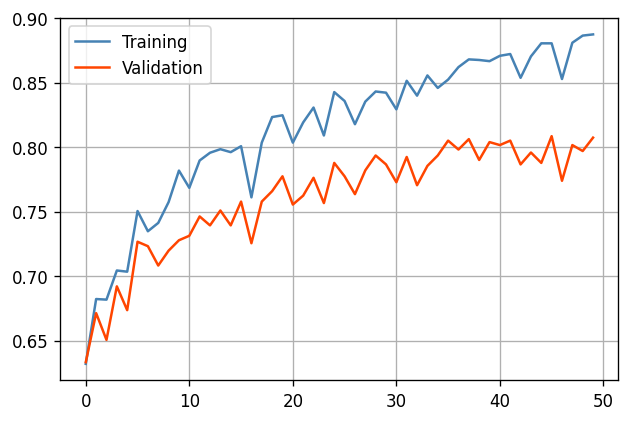

In [18]:
# TRAINING VISUALIZATION

fig, ax = plt.subplots(dpi=120)

ax.plot(train_accs, c="steelblue", label="Training")
ax.plot(val_accs, c="orangered", label="Validation")
ax.grid()
ax.legend()

plt.show()

### Evaluation

In [19]:
from sklearn.metrics import confusion_matrix

In [20]:
with torch.no_grad():
    model.eval()

    test_batch = next(iter(loader_te)).to(device)

    y_pred = model(test_batch.x, test_batch.edge_index, test_batch.batch).argmax(dim=1)
    y_true = test_batch.y


In [21]:
cm = confusion_matrix(y_true.flatten().cpu(), y_pred.cpu())
print(f"""
Confusion matrix:
{cm}

Accuracy: {
    ((y_true.flatten().cpu() == y_pred.cpu()).sum() / len(y_pred)).item()
}
""")


Confusion matrix:
[[600 148]
 [ 81 473]]

Accuracy: 0.8241167664527893



## Explainability

This is the second part of this workshop.

We will focus on how to gain insight from the trained model. To this end, we introduce [GNN Explainer][1], a general,  model-agnostic approach for providing interpretable explanations for predictions of any GNN-based model on any graph-based machine learning task.

The notebook is organized as follows:

* Brief theoretical recap on GNN-EXPLAINER
* Train your GNN-EXPLAINER to explain graph classification predictions
* Visualize and understand the proposed explanation

[1]: https://github.com/RexYing/gnn-model-explainer

### GNN-explainer

Ying, Rex et al. proposed GNN EXPLAINER , an approach for explaining
predictions made by GNNs.
GNN EXPLAINER **takes a trained GNN and its prediction**, and it **returns an
explanation** in the form of a small **subgraph** of the input graph together
with a small **subset of node features** that are most influential for the
prediction.

#### HOW?

They try to maximize the **mutual information** ($MI$) with GNN's prediction $Y$
by optimizing a **subgraph** $G_S$ (to select the important subgraphs) and a
**feature mask** $X_S$: 

$$
    \underset{G_S}{\max} (Y, (G_S, X_S)) =
    H(Y) - H(y | G = G_S, X=X_S),
$$
where $H$ denotes entropy.

This obective is intractable (exponentially many subgraphs).
The authors propose a _relaxation_ and change the conditional entropy with a
**cross entropy**.
The objective becomes to learn a **graph mask** $M \in \mathbb{R}^{n \times n}$, and since $H(Y)$ is independent from the masks, our objective becomes to minimize the following:

$$
    \underset{M}{\min} -\sum_{c=1}^C \mathbf{1}_{y = c}
    \log P_{\Phi}(Y = y | G = A_c \odot \sigma(M), X = X_c).
$$

On top of that, we include constraints on the size of the mask and on the feature selector.

1. Constraint on the graph size: $\lambda_1 \| A_c \odot \sigma(M) \|_1$
1. Constraint on the graph entropy:
$ \lambda_2 H \big( A_c \odot \sigma(M) \big)$ 
1. Constraint on the number of features: $\lambda_3 \| X_c \|_1$


#### References

- Ying, Rex, et al. ["Gnnexplainer: Generating explanations for graph neural networks."][1] Advances in neural information processing systems 32 (2019): 9240.

[1]: https://arxiv.org/abs/1903.03894

#### EXERCISE

Write down the explainer loss function:

In [22]:
# EXERCISE:

def graph_loss(
    x: torch.tensor,
    edge_index: torch.tensor,
    batch_index: torch.tensor,
    expl_label: int,
    **kwargs
) -> torch.tensor:
    """Computes the explainer loss function for explanation
    of graph classificaiton tasks.

    Returns:
        loss (torch.tensor): explainer loss function, which
            is a weight sum of different terms.
    """
    # We randomly initialize the masks
    (N, F), E = x.size(), edge_index.size(1)

    node_feat_mask = torch.nn.Parameter(torch.randn(F) * 0.1)
    self.edge_mask = torch.nn.Parameter(torch.randn(E) * 0.01)

    # Get model predictions
    # NOTE: Suppose the edge mask is implicitly applied,
    # you only have to use the feature mask.

    # Prediction loss.

    # Edge mask size loss.

    # Edge mask entropy loss.

    # Feature mask size loss.

    raise NotImplementedError()


In [269]:
from math import sqrt

from torch_geometric.nn import MessagePassing
EPS = 1e-15


class GNNExplainer(torch.nn.Module):
    """The GNN-Explainer model from the `"GNNExplainer: Generating
    Explanations for Graph Neural Networks"
    <https://arxiv.org/abs/1903.03894>`_ paper for identifying compact subgraph
    structures and small subsets node features that play a crucial role in a
    GNN’s graph-prediction.
    """

    coeffs = {
        'edge_size': 0.1,
        'node_feat_size': 1.0,
        'edge_ent': 1.0,
        'node_feat_ent': 0.1,
    }

    def __init__(self, model, epochs=100, lr=0.01, log=True):
        """ Initialize GNNExplainer Class.

        Args:
            model (torch.nn.Module): The GNN module to explain.
            epochs (int, optional): The number of epochs to train.
                (default: :obj:`100`)
            lr (float, optional): The learning rate to apply.
                (default: :obj:`0.01`)
        """
        super(GNNExplainer, self).__init__()
        self.model = model
        self.epochs = epochs
        self.lr = lr
        self.log = log

    def __set_masks__(self, x, edge_index):
        """ Initialize the masks for edges and node features.

        For each module contained in the GNN model, the attribute
        __edge_mask__ is set to the initialized edge mask, so that
        this is automatically taken into account during message passing.

        Args:
            x (torch tensor): node features
            edge_index (torch tensor): pytorch geometric edge index
        """
        (N, F), E = x.size(), edge_index.size(1)

        # Node feature mask.
        self.node_feat_mask = torch.nn.Parameter(torch.randn(F) * 0.1)

        # Edge mask.
        std = torch.nn.init.calculate_gain('relu') * sqrt(2.0 / (2 * N))
        self.edge_mask = torch.nn.Parameter(torch.randn(E) * std)

        # TODO: at some point we should enforce the mask to be symmetric?
        # Maybe do this iteratively in explain graph? --> but then should
        # maybe reset the module.__edge_mask__ as below

        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                module.__explain__ = True
                module.__edge_mask__ = self.edge_mask

    def __clear_masks__(self):
        """Deletes the node and edge masks.
        """
        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                module.__explain__ = False
                module.__edge_mask__ = None
        self.node_feat_masks = None
        self.edge_mask = None

    def graph_loss(
        self,
        x: torch.tensor,
        edge_index: torch.tensor,
        batch_index: torch.tensor,
        expl_label: int,
        **kwargs
    ) -> torch.tensor:
        """Computes the explainer loss function for explanation
        of graph classificaiton tasks.

        Returns:
            loss (torch.tensor): explainer loss function, which
                is a weight sum of different terms.
        """
        # Mask node features
        h = x * self.node_feat_mask.view(1,-1).sigmoid()

        model_pred = self.model(h, edge_index, batch_index, **kwargs)
        pred_proba = torch.softmax(model_pred, 1)

        # Prediction loss.
        # TODO: 0 removes the batch dimension? So this works only
        # for batchsize = 1 currently?
        loss = -torch.log(pred_proba[:, expl_label])

        # Edge mask size loss.
        edge_mask = self.edge_mask.sigmoid()
        loss = loss + self.coeffs['edge_size'] * edge_mask.sum()

        # Edge mask entropy loss.
        ent = -edge_mask * torch.log(edge_mask + EPS) - (1 - edge_mask) * torch.log(1 - edge_mask + EPS)
        loss = loss + self.coeffs['edge_ent'] * ent.mean()

        # Feature mask size loss.
        feat_mask = self.node_feat_mask.sigmoid()
        loss = loss + self.coeffs['node_feat_size'] * feat_mask.mean()

        return loss.sum()

    def explain_graph(self, x, edge_index, batch_index, expl_label: int, **kwargs):
        """Learns and returns a node feature mask and an edge mask that play a
        crucial role to explain the prediction made by the GNN for graph
        classification.

        Args:
            x (Tensor): The node feature matrix.
            edge_index (LongTensor): The edge indices.
            batch_index (LongTensor): The batch index.
            expl_label (int): Label against which compute cross entropy

            **kwargs (optional): Additional arguments passed to the GNN module.

        Returns:
            (torch.tensor, torch.tensor): the node feature mask and edge mask
        """

        # if len(data.y) > 1:
        #     raise NotImplementedError(f"Can only explain one molecule, recieved {len(data.y)}")

        self.model.eval()
        self.__clear_masks__()

        self.__set_masks__(x, edge_index)
        self.to(x.device)

        optimizer = torch.optim.Adam([self.node_feat_mask, self.edge_mask],
                                     lr=self.lr)

        for epoch in range(self.epochs):
            optimizer.zero_grad()

            loss = self.graph_loss(x, edge_index, batch_index, expl_label, **kwargs)
            loss.backward()

            optimizer.step()

        node_feat_mask = self.node_feat_mask.detach().sigmoid()
        edge_mask = self.edge_mask.detach().sigmoid()

        self.__clear_masks__()

        return node_feat_mask, edge_mask

#### EXERCISE

Choose one graph from the dataset and plot its explanation using the `plot_mol` function.

In [307]:
from collections import defaultdict

def mask_to_dict(edge_mask, data):
    """
    Conver an `edge_mask` in pytorch geometric format to a networkx compatible
    dictionary (_{(n1, n2) : mask_value}_).
    Multiple edge appearences are averaged.
    """
    edge_mask_dict = defaultdict(float)
    counts = defaultdict(int)

    for val, u, v in zip(edge_mask.to("cpu").numpy(), *data.edge_index):
        u, v = u.item(), v.item()
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
        counts[(u,v)] += 1

    for edge, count in counts.items():
        edge_mask_dict[edge] /= count

    return edge_mask_dict



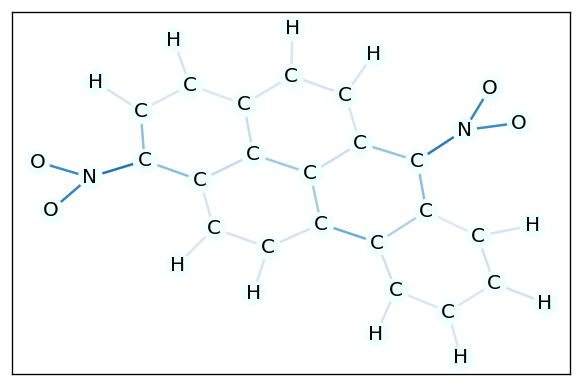

In [308]:
# EXERCISE

data = dataset[0]
data.to(device)

# Initialize explainer
explainer = GNNExplainer(model, epochs=200).to(device)

# Train explainer
model_args = (
    data.x,
    data.edge_index,
    torch.zeros(data.num_nodes, dtype=int, device=device)
)

GNNExp_feat_mask, GNNExp_edge_mask = explainer.explain_graph(
    *model_args,
    model(*model_args).argmax(dim=1)
)

mol = to_molecule(data)

GNNExp_edge_mask_dict = mask_to_dict(
    GNNExp_edge_mask,
    data
)

plot_mol(mol, edge_mask=GNNExp_edge_mask_dict)


## Interactive analysis

In [314]:
from matplotlib.colorbar import ColorbarBase
from mpl_toolkits.axes_grid1 import make_axes_locatable

def explain_graph_visualized(data):
    data.to(device)
    x = data.x
    edge_index = data.edge_index
    model.eval()

    # Initialize explainer
    explainer = GNNExplainer(model, epochs=200).to(device)
    # Train explainer
    model_args = (data.x, data.edge_index, data.batch)
    GNNExp_feat_mask, GNNExp_edge_mask = explainer.explain_graph(
        *model_args,
        model(*model_args).argmax(dim=1)
    )

    mol = to_molecule(data)

    GNNExp_edge_mask_dict = mask_to_dict(
       GNNExp_edge_mask,
       data
    )

    fig, ax = plt.subplots(
        1, 2,
        sharex=True,
        sharey=True,
        dpi=150, figsize=(10,4)
    )

    fig.tight_layout()

    plot_mol(
        mol,
        edge_type=(data.edge_attr.argmax(dim=1) + 1).to("cpu").numpy(),
        ax=ax[1]
    )
    
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes("left", "4%", pad="1%")
    cbar = ColorbarBase(
        ax=cax, cmap=plt.cm.Blues,
        ticklocation="left",
    )

    def threshold_plot(threshold):
        xlim, ylim = ax[0].get_xlim(), ax[0].get_ylim()
        ax[0].clear()
        ax[0].set_xlim(xlim), ax[0].set_ylim(ylim)
        
        plot_mol(
            mol,
            GNNExp_edge_mask_dict,
            edge_type=(data.edge_attr.argmax(dim=1) + 1).to("cpu").numpy(),
            threshold=threshold,
            ax=ax[0]
        )

        cbar.add_lines([threshold], [[1, .5, 0, 1]], 3)

        display(fig)

    plt.close()

    return interact(
        threshold_plot,
        threshold=FloatSlider(value=0.1, min=0., max=.99, step=0.05)
    )

def big_interact(which):
    idces = []
    test_size = len(y_true)
    if which == "true_pos":
        idces += [
            i for i in range(test_size)
            if y_pred[i] == y_true[i] == 0
        ]
    if which == "true_neg":
        idces += [
            i for i in range(test_size)
            if y_pred[i] == y_true[i] == 1
        ]
    if which == "false_neg":
        idces += [
            i for i in range(test_size)
            if y_pred[i] != y_true[i] == 0
        ]
    if which == "false_pos":
        idces += [
            i for i in range(test_size)
            if y_pred[i] != y_true[i] == 1
        ]

    single_loader_te = DataLoader(
        dataset[idx_val:], batch_size=1, shuffle=False
    )
    
    return interact(
        lambda data: explain_graph_visualized(data),
        data=[graph for i, graph in enumerate(list(single_loader_te)) if i in idces],
    )

################################################################################

interact(
    big_interact,
    which=["true_pos", "true_neg", "false_pos", "false_neg"]
)

interactive(children=(Dropdown(description='which', options=('true_pos', 'true_neg', 'false_pos', 'false_neg')…

<function __main__.big_interact>